# Stock Data Exploration and Forecast Preparation

This notebook demonstrates how to:
1. **Download historical stock data** for a chosen ticker (Apple in this example).
2. **Explore** and analyze the data (shape, head/tail samples, etc.).
3. **Split** the time series into training and validation sets.
4. **Prepare** the data for a forecasting task by creating input sequences (contexts) and corresponding forecast horizons.

---

In [1]:
# ===========================
#    Import Dependencies
# ===========================

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from typing import Tuple

# Optional: Set a seaborn style for nicer plots
sns.set_theme(style="whitegrid")


## 1. Download Historical Stock Data

We’ll use **yfinance** to fetch historical data for Apple (`AAPL`) from 2010-01-01 to 2019-01-01.

In [2]:
# ===========================
#   Download Stock Data
# ===========================

print("Downloading AAPL stock data...")
df = yf.download("AAPL", start="2010-01-01", end="2019-01-01")

print("\nData downloaded. Here are the first 5 rows:")
display(df.head(5))

print("Here are the last 5 rows:")
display(df.tail(5))

[*********************100%***********************]  1 of 1 completed


Data downloaded. Here are the first 5 rows:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447413,6.462175,6.398307,6.429939,493729600
2010-01-05,6.458560,6.495013,6.424516,6.465188,601904800
2010-01-06,6.355827,6.484167,6.349199,6.458559,552160000
2010-01-07,6.344078,6.386858,6.297984,6.379326,477131200
2010-01-08,6.386252,6.386855,6.298283,6.335640,447610800


Here are the last 5 rows:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-12-24,35.060497,36.187553,35.003188,35.375689,148676800
2018-12-26,37.529510,37.543837,35.034230,35.411507,234330000
2018-12-27,37.285950,37.433998,35.834153,37.211928,212468400
2018-12-28,37.305050,37.851865,36.903896,37.608305,169165600
2018-12-31,37.665627,38.052454,37.364758,37.854263,140014000


### Quick Data Information

We can check the shape of the dataset, as well as quickly verify the date range and column details.

In [3]:
# ===========================
#   Explore Basic Info
# ===========================
print(f"DataFrame shape: {df.shape}")
print("DataFrame columns:", df.columns.tolist())

print("\nStatistical summary:")
display(df.describe())

# Checking for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in each column:")
print(missing_values)

DataFrame shape: (2264, 5)
DataFrame columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]

Statistical summary:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,22.443932,22.643002,22.237106,22.446848,3.204600e+08
std,11.472167,11.567662,11.375540,11.470984,2.386709e+08
min,5.785831,5.904829,5.731602,5.795469,4.590360e+07
25%,13.198030,13.366567,13.075617,13.260331,1.376740e+08
50%,20.899574,21.028139,20.671409,20.895149,2.536010e+08
75%,28.222087,28.427333,28.007014,28.204828,4.306974e+08
max,55.221668,55.554800,54.676755,54.914722,1.880998e+09



Missing Values in each column:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


### 2. Visualize the Data

A quick plot of the closing price over time can help visualize overall trends.

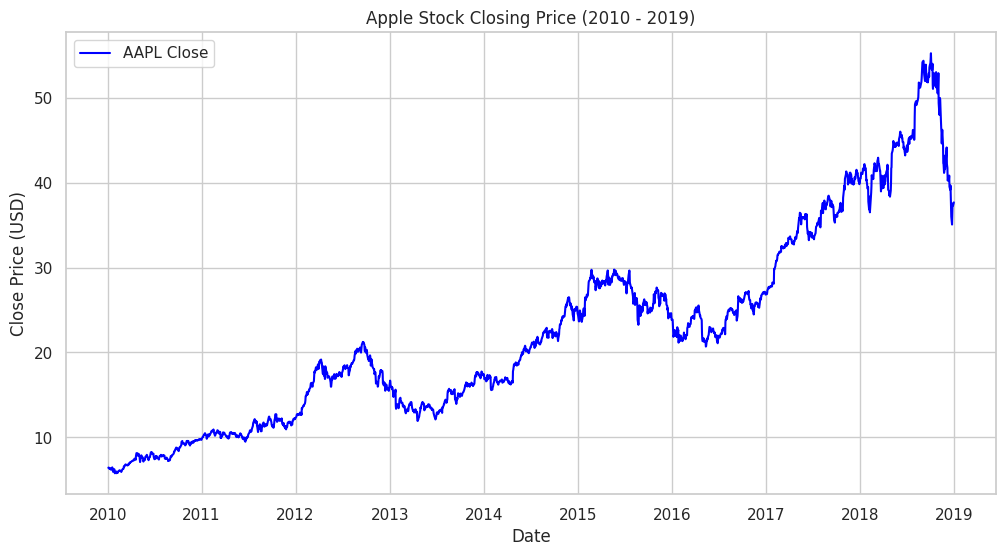

In [4]:
# ===========================
#   Plot Close Prices
# ===========================

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='AAPL Close', color='blue')
plt.title("Apple Stock Closing Price (2010 - 2019)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

## 3. Prepare Data for Forecasting

We will focus on the **Close** price. Let's convert the Close column into a NumPy array, then split the data into **training** and **validation** sets. After that, we'll create input sequences (contexts) and output sequences (horizons) for a supervised learning approach to time series forecasting.

### 3.1 Extract the Close Price and Split

- We define a `train_split` ratio (e.g., 80% of the data for training).
- We then slice the array into `train_series` and `val_series`.

In [5]:
# ===========================
#   Data Splitting
# ===========================

time_series = df["Close"].values.reshape(-1, 1)  # shape: (N, 1)

train_split = 0.8
split_idx = int(len(time_series) * train_split)

train_series = time_series[:split_idx]
val_series   = time_series[split_idx:]

print(f"Train series shape: {train_series.shape}")
print(f"Validation series shape: {val_series.shape}")

Train series shape: (1811, 1)
Validation series shape: (453, 1)


### 3.2 Define Context and Horizon Lengths

For example, we can choose:
- **`context_length`** = 50 (the number of past time steps used as input)
- **`horizon_length`** = 10 (the number of future time steps to predict)

You can modify these based on your forecasting requirements.

In [6]:
# ===========================
#   Specify Context & Horizon
# ===========================

context_length = 50
horizon_length = 10

### 3.3 Create (Context, Horizon) Samples

We slide over the training and validation series to create input-output pairs:
- `x` = the previous 50 time steps of data (context)
- `y` = the next 10 time steps (forecast horizon)

The number of samples in each set is determined by:
`num_samples` = `length of series` - `context_length` - `horizon_length` + 1

In [7]:
# ===========================
#   Build Training Samples
# ===========================

train_samples = len(train_series) - context_length - horizon_length + 1
val_samples = len(val_series) - context_length - horizon_length + 1

train_data = []
for i in range(train_samples):
    x = train_series[i : i + context_length]
    y = train_series[i + context_length : i + context_length + horizon_length]
    train_data.append((x, y))

val_data = []
for i in range(val_samples):
    x = val_series[i : i + context_length]
    y = val_series[i + context_length : i + context_length + horizon_length]
    val_data.append((x, y))

print("Created datasets:")
print(f"- Training samples: {len(train_data)}")
print(f"- Validation samples: {len(val_data)}")

# Show a few example pairs
print("\nSample pairs from training data:")
for idx in range(3):
    x_sample, y_sample = train_data[idx]
    print(
        f"Sample {idx}:\n  Context (X) shape={x_sample.shape}, first 3 elements={x_sample[:3].ravel()}\n  "
        f"Horizon (Y) shape={y_sample.shape}, first 3 elements={y_sample[:3].ravel()}"
    )

Created datasets:
- Training samples: 1752
- Validation samples: 394

Sample pairs from training data:
Sample 0:
  Context (X) shape=(50, 1), first 3 elements=[6.44741297 6.45855951 6.35582685]
  Horizon (Y) shape=(10, 1), first 3 elements=[6.7519927  6.76796007 6.69565582]
Sample 1:
  Context (X) shape=(50, 1), first 3 elements=[6.45855951 6.35582685 6.34407759]
  Horizon (Y) shape=(10, 1), first 3 elements=[6.76796007 6.69565582 6.77097321]
Sample 2:
  Context (X) shape=(50, 1), first 3 elements=[6.35582685 6.34407759 6.3862524 ]
  Horizon (Y) shape=(10, 1), first 3 elements=[6.69565582 6.77097321 6.87972927]


## 4. Creating a PyTorch Dataset (Optional)

Below is an example of a custom PyTorch `Dataset` class to handle this data. If you use another framework or a pure NumPy workflow, adapt accordingly.

In [8]:
# ======================================
#   PyTorch Dataset for Time Series
# ======================================

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        """
        data: List of (context, horizon) tuples.
        Each context and horizon is expected to be a NumPy array.
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        # Convert x and y to float32 if using PyTorch
        return (x.astype(np.float32), y.astype(np.float32))

# Example usage:
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(val_data)

print(f"TrainDataset length: {len(train_dataset)}")
print(f"ValDataset length: {len(val_dataset)}")

# Checking one sample
sample_x, sample_y = train_dataset[0]
print("Sample shapes from train_dataset[0]:", sample_x.shape, sample_y.shape)

TrainDataset length: 1752
ValDataset length: 394
Sample shapes from train_dataset[0]: (50, 1) (10, 1)


## 5. Conclusion

- We have downloaded **AAPL** stock data.
- Performed basic data exploration (head, tail, shape, plotting).
- Split it into training and validation sets.
- Created supervised learning samples for forecasting.
- (Optionally) packaged the data into a PyTorch `Dataset`.

You can now proceed to build and train a forecasting model using these prepared datasets.

---

### Next Steps
1. **Feature Engineering**: You might add additional features such as technical indicators, date/time features (e.g. day of week, day of month), or external data.
2. **Modeling**: Use RNNs (LSTM, GRU), Transformers, or classical ML models (ARIMA, XGBoost) for forecasting.
3. **Validation**: Evaluate models on the validation set and tune hyperparameters.
4. **Deployment**: If you are satisfied with the model, proceed to deploy it or integrate it into a production environment.

**Happy Forecasting!**